In [5]:
import os
import pypsa
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

In [14]:
EXTERNAL = "/Volumes/T9"
PYPSA = os.path.abspath(os.path.join(os.getcwd(), "../..")) + '/pypsa-eur'
RESOURCES = PYPSA + "/resources/" # path to the pypsa-eur network data
DATA = PYPSA +  "/data/" # path to the pypsa-eur geo data
TK = 273.15

In [7]:
his_era5_ncfile = xr.open_dataset(EXTERNAL + f"/era5/heatwave_july/Historical_era5_July_data.nc")
his_rcp45_ncfile = xr.open_dataset(EXTERNAL + f"/rcp45/Historical_rcp45_July_data.nc")
fut_rcp45_ncfile = xr.open_dataset(EXTERNAL + f"/rcp45/Future_rcp45_July_data.nc")

In [10]:
"""
Calculate historical temperature difference between ERA5 and RCP45 from 2019-2023
"""
delta_temp_ncfile_path = EXTERNAL + f"/rcp45/Historical_delta_heatwave_July_data.nc"
if not os.path.exists(delta_temp_ncfile_path):
    his_era5_temp = his_era5_ncfile['temperature'].data
    his_rcp45_temp = his_rcp45_ncfile['temperature'].data
    ### stack 3-hour average rcp45 data for 8 times to 24-hour data
    his_rcp45_temp = np.stack([his_rcp45_temp,his_rcp45_temp,his_rcp45_temp], axis=1).reshape(-1,his_era5_temp.shape[1],his_era5_temp.shape[2])
    ncfile_slice = xr.Dataset(coords={'time': his_era5_ncfile.time.data, 
                'y': his_era5_ncfile.lat.data,
                'x': his_era5_ncfile.lon.data},
        attrs={'module': ['era5', ]}, )
    ncfile_slice['delta_temp'] = xr.DataArray(his_era5_temp - his_rcp45_temp, dims=ncfile_slice.dims, coords=ncfile_slice.coords)

    ncfile_slice.to_netcdf(delta_temp_ncfile_path)
delta_temp_ncfile = xr.open_dataset(delta_temp_ncfile_path)

In [13]:
"""
# Load country power grid files (or regions of interests with coordinates)
"""
country_name = {'BE': 'Belgium', 'IT': 'Italy', 'ES': 'Spain', 'GB': 'UK', 'FR': 'France', 'DE': 'Germany'}
selected_country = [ 'BE', 'IT', 'ES', 'FR', 'GB', 'DE'][2]
rcp = 45
network_filename = RESOURCES + f"{selected_country}/networks/elec_s.nc"  
network = pypsa.Network(network_filename)
### save bus coordinates to filter weather information
bus_loc_list = network.buses[['x','y']].values
x_da = xr.DataArray(bus_loc_list[:,0], dims=["bus"])
y_da = xr.DataArray(bus_loc_list[:,1], dims=["bus"])

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, storage_units


In [37]:
"""
# Set parameters for heatwave generation
"""
fut_year = 2030 # 2025-2030
his_year = 2022 # 2019-2024
heatwave_month = 7 # 6-8
date_s = datetime(his_year, heatwave_month, 1, 0)
date_e = datetime(his_year, heatwave_month, 31, 23)
fut_date_s = datetime(fut_year, heatwave_month, 1, 0)
fut_date_e = datetime(fut_year, heatwave_month, 31, 23)

In [38]:
### data preparation
his_era5_ncfile_slice = his_era5_ncfile.sel(time=slice(date_s, date_e))
his_rcp45_ncfile_slice = his_rcp45_ncfile.sel(time=slice(date_s, date_e))
his_delta_temp_slice = delta_temp_ncfile.sel(time=slice(date_s, date_e))
fut_rcp45_ncfile_slice = fut_rcp45_ncfile.sel(time=slice(fut_date_s, fut_date_e))
### filter temperature value with bus coordinates
bus_his_era5_temp = his_era5_ncfile_slice.sel(x=x_da, y=y_da, method='nearest')['temperature'].data - TK
bus_his_rcp45_temp = his_rcp45_ncfile_slice.sel(x=x_da, y=y_da, method='nearest')['temperature'].data - TK
bus_fut_rcp45_temp = fut_rcp45_ncfile_slice.sel(x=x_da, y=y_da, method='nearest')['temperature'].data - TK
bus_fut_delta_temp = his_delta_temp_slice.sel(x=x_da, y=y_da, method='nearest')['delta_temp'].data 
### repeat three-hour average temperature for 24-hour data
bus_his_rcp45_temp = np.stack([bus_his_rcp45_temp,bus_his_rcp45_temp,bus_his_rcp45_temp],axis=1).reshape(-1, len(bus_loc_list))
bus_fut_rcp45_temp = np.stack([bus_fut_rcp45_temp,bus_fut_rcp45_temp,bus_fut_rcp45_temp],axis=1).reshape(-1, len(bus_loc_list))


### Simulating heatwave by morphing approach

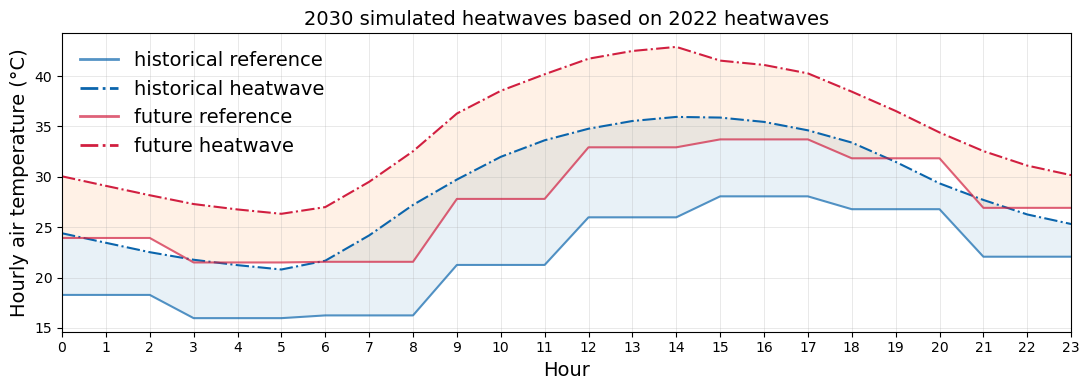

In [40]:
### find those hottest days with highest spatially-average temperature
his_hot_index = bus_his_era5_temp.mean(1).reshape(-1,24).mean(1).argmax()
future_hot_index = bus_fut_rcp45_temp.mean(1).reshape(-1,24).mean(1).argmax()

### visualize the spatial-average temperature on hottest days
historical_baseline = bus_his_rcp45_temp[his_hot_index*24: his_hot_index*24+24, :].mean(1)
historical_heatwave = bus_his_era5_temp[his_hot_index*24: his_hot_index*24+24, :].mean(1)
delta_temp = bus_fut_delta_temp[his_hot_index*24: his_hot_index*24+24, :].mean(1)
future_baseline = bus_fut_rcp45_temp[future_hot_index*24: future_hot_index*24+24, :].mean(1)

### morphing approach
future_heatwave = future_baseline + delta_temp

plt.figure(figsize=[11,4])
plt.fill_between(range(24), historical_baseline, historical_heatwave, alpha=0.1)
plt.plot(historical_baseline, c='#0B65AC', alpha=0.7)
plt.plot(historical_heatwave,  c='#0B65AC', linestyle = '-.')

plt.fill_between(range(24), future_baseline, future_heatwave, alpha=0.1)
plt.plot(future_baseline,  c='#D11F40', alpha=0.7)
plt.plot(future_heatwave,  c='#D11F40', linestyle = '-.')
plt.xlim(0, 23)
plt.xticks(range(24))
plt.yticks(range(15,51,5))
plt.title(f'{fut_year} simulated heatwaves based on {his_year} heatwaves', fontsize=14)


plt.plot([], label='historical reference', c='#0B65AC', alpha=0.7, linewidth=2)
plt.plot([], label='historical heatwave', c='#0B65AC', linestyle = '-.', linewidth=2)
plt.plot([], label='future reference', c='#D11F40', alpha=0.7, linewidth=2)
plt.plot([], label='future heatwave', c='#D11F40', linestyle = '-.', linewidth=2)

plt.xlabel('Hour',fontsize=14)
plt.ylabel('Hourly air temperature (°C)', fontsize=14)
plt.legend(ncol=1, loc=2,  fontsize=14, frameon=False)
plt.grid(linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), "..")) + f'/models/heatwave/heatwave_{selected_country}_{fut_year}_{his_year}.png', dpi=300)
plt.show()

### Simulating multiple heatwaves based on different historical hottest days

Historical heatwave days <xarray.DataArray 'time' (time: 5)> Size: 40B
array(['2022-07-14T00:00:00.000000000', '2022-07-17T00:00:00.000000000',
       '2022-07-13T00:00:00.000000000', '2022-07-16T00:00:00.000000000',
       '2022-07-15T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 40B 2022-07-14 2022-07-17 ... 2022-07-15
Future heatwave days <xarray.DataArray 'time' (time: 5)> Size: 40B
array(['2030-07-31T01:30:00.000000000', '2030-07-30T01:30:00.000000000',
       '2030-07-24T01:30:00.000000000', '2030-07-23T01:30:00.000000000',
       '2030-07-20T01:30:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 40B 2030-07-31T01:30:00 ... 2030-07-20T01:...


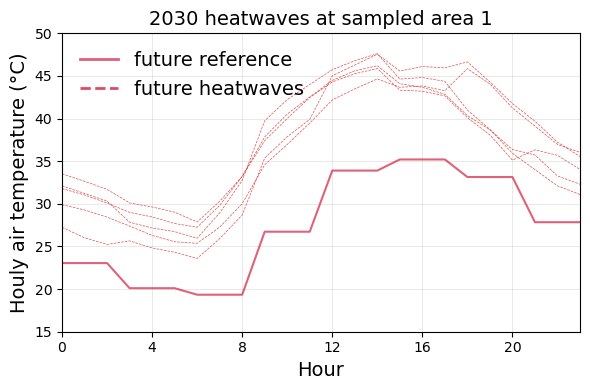

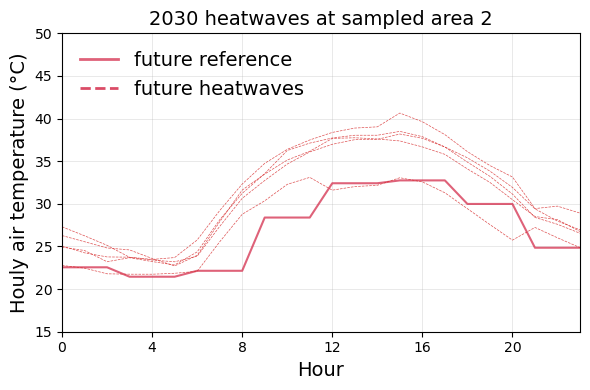

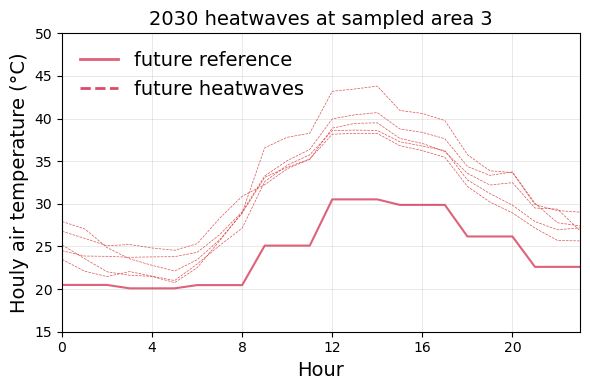

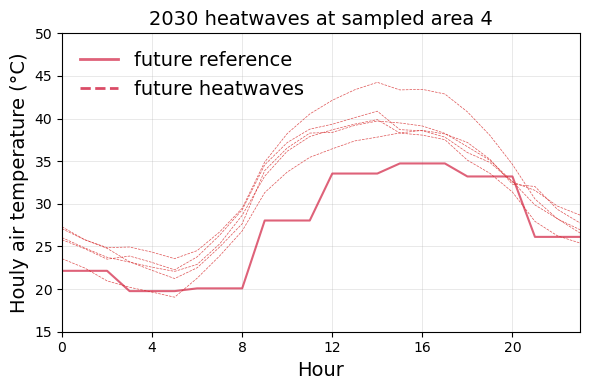

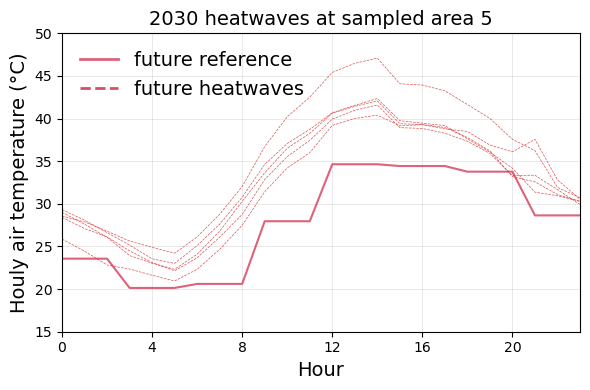

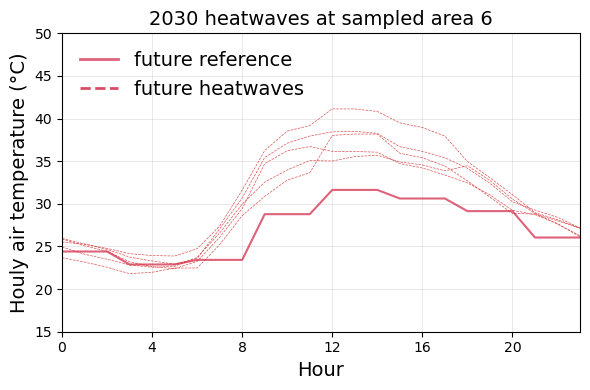

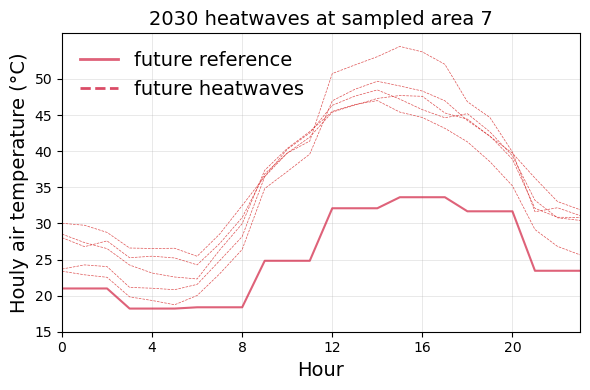

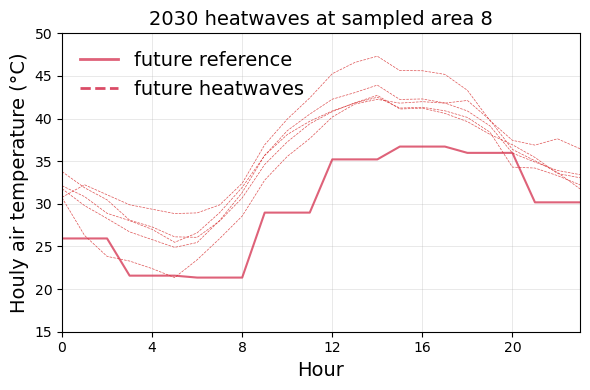

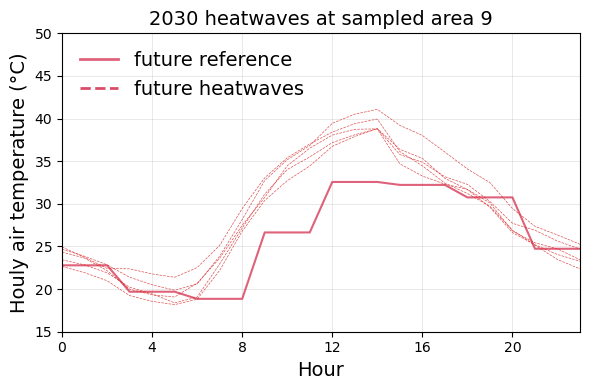

In [43]:
# hot_index = bus_his_era5_temp.mean(1)[hour_index::24].argsort()[::-1]
ave_his_era5_temp = bus_his_era5_temp.mean(1).reshape(-1,24).mean(1)
his_hot_index_list = ave_his_era5_temp.argsort()[::-1]
ave_fut_rcp45_temp = bus_fut_rcp45_temp.mean(1).reshape(-1,24).mean(1)
future_hot_index_list = ave_fut_rcp45_temp.argsort()[::-1]
fut_hot_index = future_hot_index_list[0]
print('Historical heatwave days', his_delta_temp_slice.time[his_hot_index_list[:5]*24])
print('Future heatwave days', fut_rcp45_ncfile_slice.time[future_hot_index_list[:5]*8])


### randomly pick bus areas
np.random.seed(2025)
random_indices = np.random.choice(range(bus_his_era5_temp.shape[1]), 9, replace=False)
for k, bus_index in enumerate(random_indices):
    future_baseline = bus_fut_rcp45_temp[fut_hot_index*24: fut_hot_index*24+24, bus_index]
    historical_delta_temp = []
    ### consider top 5-10 historically hottest day for future heatwave generation
    for i in his_hot_index_list[:5]:
        delta_temp = bus_fut_delta_temp[i*24: i*24+24, bus_index]
        historical_delta_temp.append(delta_temp)
    historical_delta_temp = np.stack(historical_delta_temp, axis=0)

    plt.figure(figsize=[6,4])
    plt.plot(future_baseline, c='#D11F40', alpha=0.7)
    for i in range(historical_delta_temp.shape[0]):
        future_heatwave = future_baseline + historical_delta_temp[i]
        plt.plot(future_heatwave, label=None, c='C3', linestyle = '--', linewidth=0.5, alpha=0.8)



    plt.plot([], label='future reference', c='#D11F40', linewidth=2, alpha=0.7)
    plt.plot([], label='future heatwaves', c='#D11F40', linestyle = '--', linewidth=2, alpha=0.8)

    plt.xlim(0, 23)
    plt.xticks(range(0,24,4))
    plt.yticks(range(15,51,5))
    plt.title(f'{fut_year} heatwaves at sampled area {k+1}', fontsize=14)
    # with coordinates [{y_da[bus_index].values:.2f}, {x_da[bus_index].values:.2f}]
    plt.xlabel('Hour',fontsize=14)
    plt.ylabel('Houly air temperature (°C)', fontsize=14)
    plt.grid(linewidth=0.4, alpha=0.5)
    plt.legend(ncol=1,  fontsize=14, loc=2, frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.abspath(os.path.join(os.getcwd(), "..")) + f'/models/heatwave/{k}_temperal_heatwave_{selected_country}_{fut_year}_{his_year}.png', dpi=300)
